In [2]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 9.0 MB/s eta 0:00:0000:0100:01


In [8]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np

In [14]:
# Start H2O
h2o.init()

# Load data
df = pd.read_csv("/Users/christinadong/Documents/MLops/auto_ml/athletes.csv")

# Drop irrelevant/missing columns
df = df.dropna(subset=[
    'region','age','weight','height','howlong','gender','eat',
    'train','background','experience','schedule','howlong',
    'deadlift','candj','snatch','backsq','experience',
    'background','schedule','howlong'
])
df = df.drop(columns=[
    'affiliate','team','name','athlete_id','fran','helen','grace',
    'filthy50','fgonebad','run400','run5k','pullups','train'
])

# Remove outliers
df = df[df['weight'] < 1500]
df = df[df['gender'] != '--']
df = df[df['age'] >= 18]
df = df[(df['height'] < 96) & (df['height'] > 48)]

df = df[((df['deadlift'] > 0) & (df['deadlift'] <= 1105)) | 
        ((df['gender'] == 'Female') & (df['deadlift'] <= 636))]
df = df[(df['candj'] > 0) & (df['candj'] <= 395)]
df = df[(df['snatch'] > 0) & (df['snatch'] <= 496)]
df = df[(df['backsq'] > 0) & (df['backsq'] <= 1069)]

# Clean survey data
df = df.replace({'Decline to answer|': np.nan})
df = df.dropna(subset=['background','experience','schedule','howlong','eat'])

df['total_lift'] = df['deadlift'] + df['candj'] + df['snatch'] + df['backsq']

h2o_df = h2o.H2OFrame(df)

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,9 mins 38 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 24 days
H2O_cluster_name:,H2O_from_python_christinadong_8atvgy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.846 Gb
H2O_cluster_total_cores:,14
H2O_cluster_allowed_cores:,14
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Set target and features
target = 'total_lift' 
features = [col for col in h2o_df.columns if col != target]

# Run H2O AutoML
aml = H2OAutoML(max_models=10, seed=42, sort_metric="RMSE")
aml.train(x=features, y=target, training_frame=h2o_df)

# View leaderboard
lb = aml.leaderboard
print(lb.head(rows=10))

AutoML progress: |
21:37:07.679: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                     rmse       mse      mae        rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_2_20250721_213707   3.27341   10.7152  1.7384     0.0377335                   10.7152
StackedEnsemble_AllModels_1_AutoML_2_20250721_213707      3.50528   12.287   1.64818    0.0366127                   12.287
DeepLearning_1_AutoML_2_20250721_213707                   4.53153   20.5348  2.22259    0.0461699                   20.5348
GLM_1_AutoML_2_20250721_213707                            4.94308   24.434   3.74773    0.0275872                   24.434
GBM_5_AutoML_2_20250721_213707                            6.91191   47.7746  3.85836    0.0203196                   47.7746
GBM_2_AutoML_2_20250721_213707                            7.56569   57.2397  4.14391    0.0352141   

## Top 5 Features

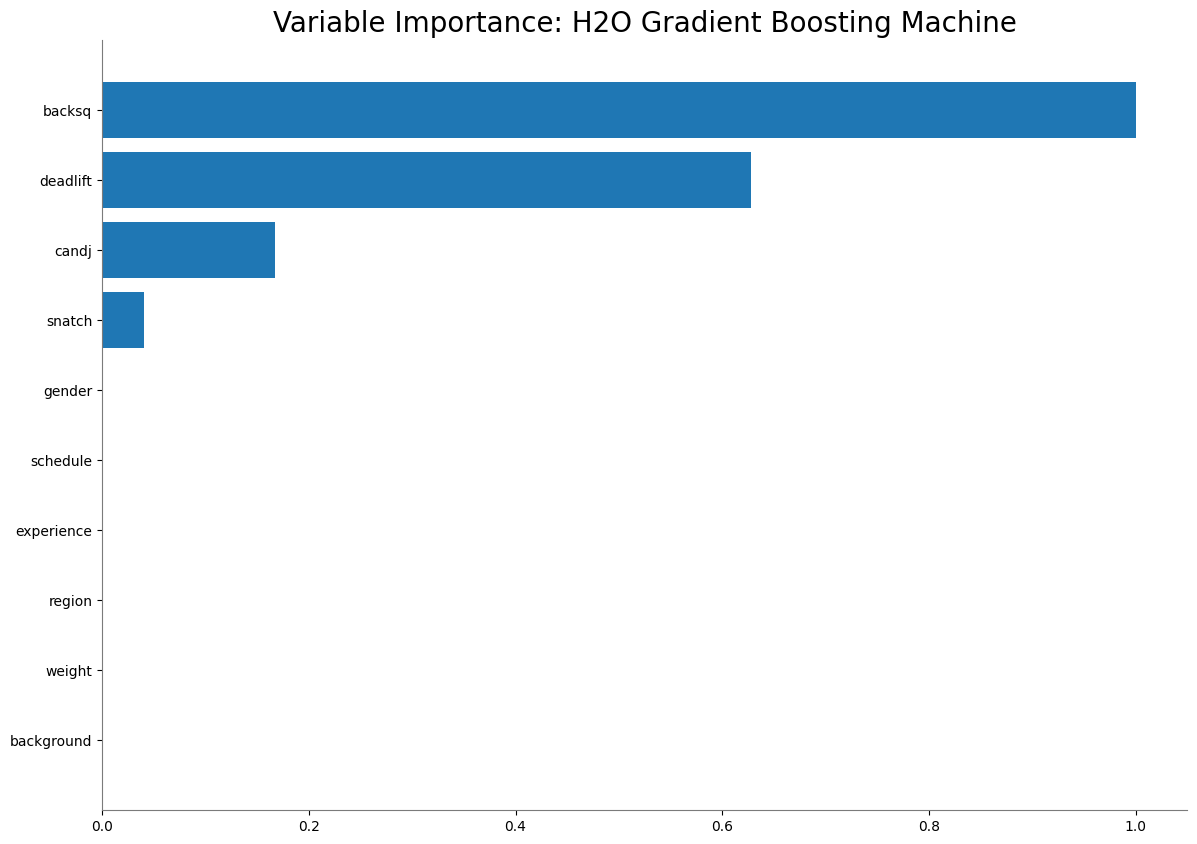

<Figure size 640x480 with 0 Axes>

In [20]:
gbm_model = h2o.get_model("GBM_5_AutoML_2_20250721_213707")
gbm_model.varimp_plot()

## Top 3 Features

In [21]:
top_features = ['backsq', 'deadlift', 'candj'] 
aml_top = H2OAutoML(max_models=10, seed=42, sort_metric="RMSE")
aml_top.train(x=top_features, y=target, training_frame=h2o_df)


AutoML progress: |
21:47:26.948: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),10/10
# GBM base models (used / total),6/6
# GLM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),2/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
